In [1]:
# imports and plotting configuration
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

from matplotlib import lines as mlines
from multisim import MultiSim
from scipy import interpolate

# set plotting style
plt.style.use(['default', 'biophysics.mplstyle'])

# define figure save directory
fig_dir = Path('paper_figures')
fig_dir.mkdir(exist_ok=True)

## Functions

In [2]:
# define interpolator function
def plot_interpolated_curve(ax, x, y, color, label=None,):
    # Ensure the data is sorted by x (required for interpolation)
    sorted_indices = np.argsort(x)
    x_sorted = np.array(x)[sorted_indices]
    y_sorted = np.array(y)[sorted_indices]

    # Create the interpolator
    interpolator = interpolate.PchipInterpolator(x_sorted, y_sorted)

    # Generate a smooth range of x values
    x_smooth = np.linspace(min(x_sorted), max(x_sorted), 500)
    y_smooth = interpolator(x_smooth)

    # Plot the interpolated curve
    ax.plot(x_smooth, y_smooth, color=color, linestyle='--')

In [3]:
# define a function to load data from paper_data2
def load_data(dir_name: str, is_tau: bool, true_data: bool):
    # define the path to the data based on dir name
    data_path = Path('paper_data2') / dir_name / f"{dir_name}_{str(true_data).lower()}"
    # print(data_path)

    # load simulation data into a multisim object
    multisim = MultiSim(file_dir=data_path)

    # create a simulation averages DF
    flen_df = pd.DataFrame([
        {
            'tau_on': sim.get_param('tau_on'),
            'tau_off': sim.get_param('tau_off'),
            'map6_on': sim.get_param('map6_on'),
            'map6_off': sim.get_param('map6_off'),
            'dt': sim.get_param('dt'),
            'fin_len': sim.get_length_at(sim.get_nsteps()-1),
            'tau_frac_tip': sim.get_tau_frac_tip(),
            'map6_frac_tip': sim.get_map6_frac_tip(),
            'tau_frac_length': sim.get_tau_frac_length(),
            'map6_frac_length': sim.get_map6_frac_length(),
            'tau_plus_end_asym': sim.get_tau_plus_end_asym(),
            'map6_plus_end_asym': sim.get_map6_plus_end_asym(),
        }
        for sim in multisim.get_iter()
    ])

    # group the df
    if is_tau:
        flen_grouped = flen_df[['tau_on', 'fin_len']].groupby('tau_on')
    else:
        flen_grouped = flen_df[['map6_on', 'fin_len']].groupby('map6_on')

    # compute flen stats
    flen_stats = pd.DataFrame({
        'mean_fin_len': flen_grouped.mean()['fin_len'],
        'std_fin_len': flen_grouped.std()['fin_len']/np.sqrt(flen_grouped.count()['fin_len']),
    })

    # group the stats df
    # if is_tau:
    #     mean_flen_df = flen_stats.groupby('tau_on').mean()
    # else:
    #     mean_flen_df = flen_stats.groupby('map6_on').mean()

    # get an asym_df
    # asym_df = mean_flen_df[['tau_plus_end_asym', 'map6_plus_end_asym']]

    # define a grouped distribution dataframe
    if is_tau:
        grouped_dist_df = flen_df[['tau_on', 'tau_frac_tip', 'map6_frac_tip', 'tau_frac_length', 'map6_frac_length']].groupby('tau_on')
    else:
        grouped_dist_df = flen_df[['map6_on', 'tau_frac_tip', 'map6_frac_tip', 'tau_frac_length', 'map6_frac_length']].groupby('map6_on')

    # compute the stats df using standard error
    grouped_dist_stats = pd.DataFrame({
        'mean_tau_frac_tip': grouped_dist_df.mean()['tau_frac_tip'],
        'std_tau_frac_tip': grouped_dist_df.std()['tau_frac_tip']/np.sqrt(grouped_dist_df.count()['tau_frac_tip']),
        'mean_map6_frac_tip': grouped_dist_df.mean()['map6_frac_tip'],
        'std_map6_frac_tip': grouped_dist_df.std()['map6_frac_tip']/np.sqrt(grouped_dist_df.count()['map6_frac_tip']),
        'mean_tau_frac_len': grouped_dist_df.mean()['tau_frac_length'],
        'std_tau_frac_len': grouped_dist_df.std()['tau_frac_length']/np.sqrt(grouped_dist_df.count()['tau_frac_length']),
        'mean_map6_frac_len': grouped_dist_df.mean()['map6_frac_length'],
        'std_map6_frac_len': grouped_dist_df.std()['map6_frac_length']/np.sqrt(grouped_dist_df.count()['map6_frac_length']),
    })

    # return dataframes
    return flen_stats, grouped_dist_stats

In [4]:
# define a function to attempt to load data from a .pkl file saved to a tmp dir
# if the pkl doesnt exist, call load_data
def load_data_from_pkl(dir_name: str, is_tau: bool, true_data: bool):
    # define the path to the data based on dir name
    data_path = Path('tmp') / dir_name / f"{dir_name}_{str(true_data).lower()}.pkl"
    flen_path = data_path
    grouped_path = Path(str(data_path).replace('.pkl', '_dist.pkl'))

    # check if the pkl exists
    if data_path.exists() and grouped_path.exists():
        # load the pkl
        flen_stats = pd.read_pickle(flen_path)
        grouped_dist_stats = pd.read_pickle(grouped_path)
        print(f"Loaded data from {data_path}")
    else:
        # load the data
        flen_stats, grouped_dist_stats = load_data(dir_name, is_tau, true_data)

        # save the data to a pkl
        data_path.parent.mkdir(parents=True, exist_ok=True)
        flen_stats.to_pickle(flen_path)
        grouped_dist_stats.to_pickle(grouped_path)
        print(f"Loaded data from {dir_name} and saved to {data_path}")

    # return the data
    return flen_stats, grouped_dist_stats

## Figure I

In [5]:
# load the data from simulation group 'fig6' and 'fig3'
fig6_flen_stats, fig6_grouped_dist_stats = load_data_from_pkl('fig6', True, True)
fig3_flen_stats, fig3_grouped_dist_stats = load_data_from_pkl('fig3', False, True)

Loaded data from fig6 and saved to tmp/fig6/fig6_true.pkl
Loaded data from fig3 and saved to tmp/fig3/fig3_true.pkl


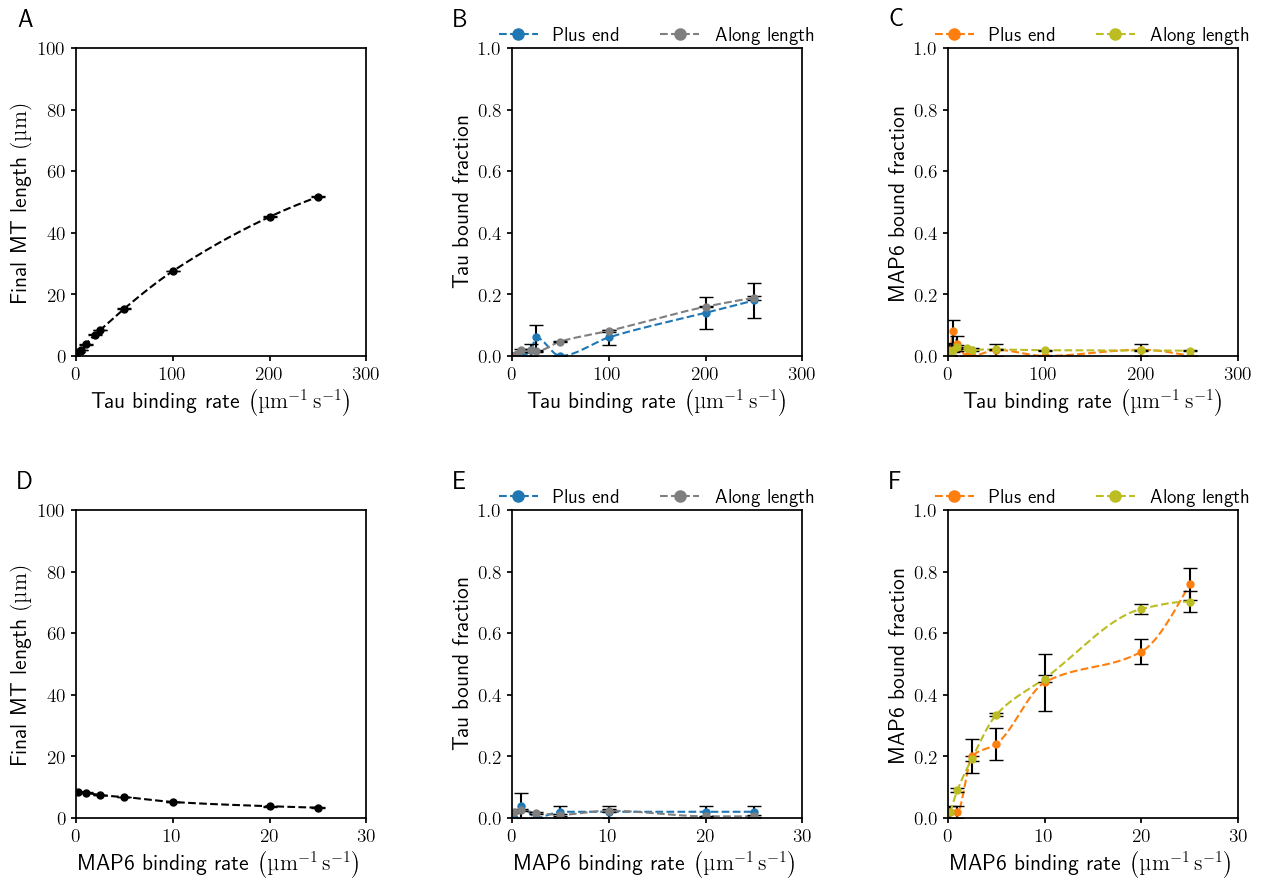

In [6]:
# create the figure object
fig, ((axA, axB, axC), (axD, axE, axF)) = plt.subplots(2, 3, figsize=(15, 10))
plt.subplots_adjust(hspace=0.5, wspace=0.5)

# sort the axes
axs = [axA, axB, axC, axD, axE, axF]
tau_axs = [axA, axB, axC]
map6_axs = [axD, axE, axF]
fin_len_axs = [axA, axD]
tau_frac_axs = [axB, axE]
map6_frac_axs = [axC, axF]

# label the plots alphabetically
for i, label in enumerate(['A', 'B', 'C', 'D', 'E', 'F']):
    axs[i].text(-0.2, 1.125, label, transform=axs[i].transAxes, fontsize=18, fontweight='bold', va='top')

# define horizontal axis labels
tau_label = r"Tau binding rate $\left(\qty{}{\per\micro\meter\per\second}\right)$"
map6_label = r"MAP6 binding rate $\left(\qty{}{\per\micro\meter\per\second}\right)$"

# define vertical axis labels
fin_len_label = r"Final MT length $\left(\qty{}{\micro\meter}\right)$"
tau_frac_label = r"Tau bound fraction"
map6_frac_label = r"MAP6 bound fraction"

# define horizontal axis limits
tau_lim = [0, 300]
map6_lim = [0, 30]

# define vertical axis limits
fin_len_lim = [0, 100]
frac_lim = [0, 1]

# set labels
for ax in tau_axs:
    ax.set_xlabel(tau_label)
    ax.set_xlim(tau_lim)

for ax in map6_axs:
    ax.set_xlabel(map6_label)
    ax.set_xlim(map6_lim)

for ax in fin_len_axs:
    ax.set_ylabel(fin_len_label)
    ax.set_ylim(fin_len_lim)

for ax in tau_frac_axs:
    ax.set_ylabel(tau_frac_label)
    ax.set_ylim(frac_lim)

for ax in map6_frac_axs:
    ax.set_ylabel(map6_frac_label)
    ax.set_ylim(frac_lim)


# plot A
axA_tau_on = fig6_flen_stats.index
axA_fin_len = fig6_flen_stats['mean_fin_len']
axA_fin_len_std = fig6_flen_stats['std_fin_len']

plot_interpolated_curve(axA, axA_tau_on, axA_fin_len, color='black')
axA.errorbar(
    axA_tau_on,
    axA_fin_len,
    yerr=axA_fin_len_std,
    fmt='o',
    capsize=5,
    markersize=5,
    label="MT length",
    color='black'
)


# plot B
axB_tau_on = fig6_grouped_dist_stats.index
axB_plus_end_frac = fig6_grouped_dist_stats['mean_tau_frac_tip']
axB_plus_end_frac_std = fig6_grouped_dist_stats['std_tau_frac_tip']
axB_len_frac = fig6_grouped_dist_stats['mean_tau_frac_len']
axB_len_frac_std = fig6_grouped_dist_stats['std_tau_frac_len']

plot_interpolated_curve(axB, axB_tau_on, axB_plus_end_frac, color='tab:blue')
axB.errorbar(
    axB_tau_on,
    axB_plus_end_frac,
    yerr=axB_plus_end_frac_std,
    fmt='o',
    capsize=5,
    markersize=5,
    label="Plus end",
    color='tab:blue',
    ecolor='black'
)

plot_interpolated_curve(axB, axB_tau_on, axB_len_frac, color='tab:grey')
axB.errorbar(
    axB_tau_on,
    axB_len_frac,
    yerr=axB_len_frac_std,
    fmt='o',
    capsize=5,
    markersize=5,
    label="Along length",
    color='tab:grey',
    ecolor='black'
)

axB.legend(
    handles=[
        mlines.Line2D([0], [0], color='tab:blue', marker='o', linestyle='--', label=r'Plus end'),
        mlines.Line2D([0], [0], color='tab:grey', marker='o', linestyle='--', label=r'Along length'),
    ],
    loc='upper center',
    ncols=2,
    bbox_to_anchor=(0.5, 1.125),
)


# plot C
axC_tau_on = fig6_grouped_dist_stats.index
axC_plus_end_frac = fig6_grouped_dist_stats['mean_map6_frac_tip']
axC_plus_end_frac_std = fig6_grouped_dist_stats['std_map6_frac_tip']
axC_len_frac = fig6_grouped_dist_stats['mean_map6_frac_len']
axC_len_frac_std = fig6_grouped_dist_stats['std_map6_frac_len']

plot_interpolated_curve(axC, axC_tau_on, axC_plus_end_frac, color='tab:orange')
axC.errorbar(
    axC_tau_on,
    axC_plus_end_frac,
    yerr=axC_plus_end_frac_std,
    fmt='o',
    capsize=5,
    markersize=5,
    label="Plus end",
    color='tab:orange',
    ecolor='black'
)

plot_interpolated_curve(axC, axC_tau_on, axC_len_frac, color='tab:olive')
axC.errorbar(
    axC_tau_on,
    axC_len_frac,
    yerr=axC_len_frac_std,
    fmt='o',
    capsize=5,
    markersize=5,
    label="Along length",
    color='tab:olive',
    ecolor='black'
)

axC.legend(
    handles=[
        mlines.Line2D([0], [0], color='tab:orange', marker='o', linestyle='--', label=r'Plus end'),
        mlines.Line2D([0], [0], color='tab:olive', marker='o', linestyle='--', label=r'Along length'),
    ],
    loc='upper center',
    ncols=2,
    bbox_to_anchor=(0.5, 1.125),
)


# plot D
axD_map6_on = fig3_flen_stats.index
axD_fin_len = fig3_flen_stats['mean_fin_len']
axD_fin_len_std = fig3_flen_stats['std_fin_len']

plot_interpolated_curve(axD, axD_map6_on, axD_fin_len, color='black')
axD.errorbar(
    axD_map6_on,
    axD_fin_len,
    yerr=axD_fin_len_std,
    fmt='o',
    capsize=5,
    markersize=5,
    label="MT length",
    color='black'
)

# plot E
axE_map6_on = fig3_grouped_dist_stats.index
axE_plus_end_frac = fig3_grouped_dist_stats['mean_tau_frac_tip']
axE_plus_end_frac_std = fig3_grouped_dist_stats['std_tau_frac_tip']
axE_len_frac = fig3_grouped_dist_stats['mean_tau_frac_len']
axE_len_frac_std = fig3_grouped_dist_stats['std_tau_frac_len']

plot_interpolated_curve(axE, axE_map6_on, axE_plus_end_frac, color='tab:blue')
axE.errorbar(
    axE_map6_on,
    axE_plus_end_frac,
    yerr=axE_plus_end_frac_std,
    fmt='o',
    capsize=5,
    markersize=5,
    label="Plus end",
    color='tab:blue',
    ecolor='black'
)

plot_interpolated_curve(axE, axE_map6_on, axE_len_frac, color='tab:grey')
axE.errorbar(
    axE_map6_on,
    axE_len_frac,
    yerr=axE_len_frac_std,
    fmt='o',
    capsize=5,
    markersize=5,
    label="Along length",
    color='tab:grey',
    ecolor='black'
)

axE.legend(
    handles=[
        mlines.Line2D([0], [0], color='tab:blue', marker='o', linestyle='--', label=r'Plus end'),
        mlines.Line2D([0], [0], color='tab:grey', marker='o', linestyle='--', label=r'Along length'),
    ],
    loc='upper center',
    ncols=2,
    bbox_to_anchor=(0.5, 1.125),
)


# plot F
axF_map6_on = fig3_grouped_dist_stats.index
axF_plus_end_frac = fig3_grouped_dist_stats['mean_map6_frac_tip']
axF_plus_end_frac_std = fig3_grouped_dist_stats['std_map6_frac_tip']
axF_len_frac = fig3_grouped_dist_stats['mean_map6_frac_len']
axF_len_frac_std = fig3_grouped_dist_stats['std_map6_frac_len']

plot_interpolated_curve(axF, axF_map6_on, axF_plus_end_frac, color='tab:orange')
axF.errorbar(
    axF_map6_on,
    axF_plus_end_frac,
    yerr=axF_plus_end_frac_std,
    fmt='o',
    capsize=5,
    markersize=5,
    label="Plus end",
    color='tab:orange',
    ecolor='black'
)

plot_interpolated_curve(axF, axF_map6_on, axF_len_frac, color='tab:olive')
axF.errorbar(
    axF_map6_on,
    axF_len_frac,
    yerr=axF_len_frac_std,
    fmt='o',
    capsize=5,
    markersize=5,
    label="Along length",
    color='tab:olive',
    ecolor='black'
)

axF.legend(
    handles=[
        mlines.Line2D([0], [0], color='tab:orange', marker='o', linestyle='--', label=r'Plus end'),
        mlines.Line2D([0], [0], color='tab:olive', marker='o', linestyle='--', label=r'Along length'),
    ],
    loc='upper center',
    ncols=2,
    bbox_to_anchor=(0.5, 1.125),
)


# save figure
fig_file = fig_dir / 'finfigs' / 'figI.pdf'
fig_file.parent.mkdir(exist_ok=True)
fig.savefig(fig_file, bbox_inches='tight')

# create a dataframe of all the plot data
# label the columns as X and Y for each plot
# save the data to a csv file
# data_df = pd.DataFrame({
#     'A_X': axA_tau_on,
#     'A_Y': axA_fin_len,
#     'B_X': axB_tau_on,
#     'B_Y': axB_plus_end_frac,
#     'C_X': axC_tau_on,
#     'C_Y': axC_plus_end_frac,
#     'D_X': axD_map6_on,
#     'D_Y': axD_fin_len,
#     'E_X': axE_map6_on,
#     'E_Y': axE_plus_end_frac,
#     'F_X': axF_map6_on,
#     'F_Y': axF_plus_end_frac,
# })
# data_df.to_csv(fig_dir / 'finfigs' / 'figI_data.csv', index=False)

## Figure II

In [7]:
# load the data from simulation group 'fig2' and 'fig4'
fig2_flen_stats, fig2_grouped_dist_stats = load_data_from_pkl('fig2', True, True)
fig4_flen_stats, fig4_grouped_dist_stats = load_data_from_pkl('fig4', False, True)

Loaded data from fig2 and saved to tmp/fig2/fig2_true.pkl
Loaded data from fig4 and saved to tmp/fig4/fig4_true.pkl


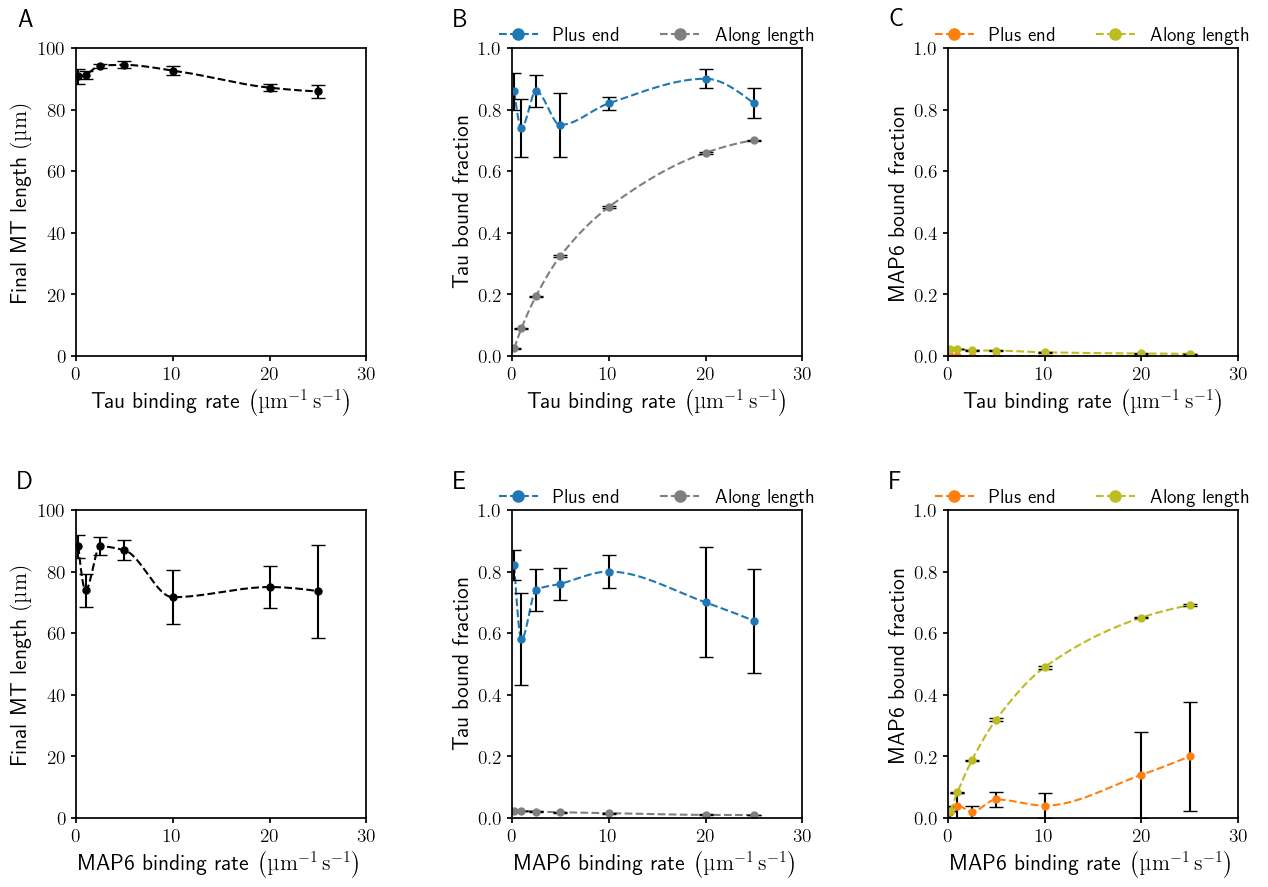

In [ ]:
# create the figure object
fig, ((axA, axB, axC), (axD, axE, axF)) = plt.subplots(2, 3, figsize=(15, 10))
plt.subplots_adjust(hspace=0.5, wspace=0.5)

# sort the axes
axs = [axA, axB, axC, axD, axE, axF]
tau_axs = [axA, axB, axC]
map6_axs = [axD, axE, axF]
fin_len_axs = [axA, axD]
tau_frac_axs = [axB, axE]
map6_frac_axs = [axC, axF]

# label the plots alphabetically
for i, label in enumerate(['A', 'B', 'C', 'D', 'E', 'F']):
    axs[i].text(-0.2, 1.125, label, transform=axs[i].transAxes, fontsize=18, fontweight='bold', va='top')

# define horizontal axis labels
tau_label = r"Tau binding rate $\left(\qty{}{\per\micro\meter\per\second}\right)$"
map6_label = r"MAP6 binding rate $\left(\qty{}{\per\micro\meter\per\second}\right)$"

# define vertical axis labels
fin_len_label = r"Final MT length $\left(\qty{}{\micro\meter}\right)$"
tau_frac_label = r"Tau bound fraction"
map6_frac_label = r"MAP6 bound fraction"

# define horizontal axis limits
tau_lim = [0, 30]
map6_lim = [0, 30]

# define vertical axis limits
fin_len_lim = [0, 100]
frac_lim = [0, 1]

# set labels
for ax in tau_axs:
    ax.set_xlabel(tau_label)
    ax.set_xlim(tau_lim)

for ax in map6_axs:
    ax.set_xlabel(map6_label)
    ax.set_xlim(map6_lim)

for ax in fin_len_axs:
    ax.set_ylabel(fin_len_label)
    ax.set_ylim(fin_len_lim)

for ax in tau_frac_axs:
    ax.set_ylabel(tau_frac_label)
    ax.set_ylim(frac_lim)

for ax in map6_frac_axs:
    ax.set_ylabel(map6_frac_label)
    ax.set_ylim(frac_lim)


# plot A
axA_tau_on = fig2_flen_stats.index
axA_fin_len = fig2_flen_stats['mean_fin_len']
axA_fin_len_std = fig2_flen_stats['std_fin_len']

plot_interpolated_curve(axA, axA_tau_on, axA_fin_len, color='black')
axA.errorbar(
    axA_tau_on,
    axA_fin_len,
    yerr=axA_fin_len_std,
    fmt='o',
    capsize=5,
    markersize=5,
    label="MT length",
    color='black'
)


# plot B
axB_tau_on = fig2_grouped_dist_stats.index
axB_plus_end_frac = fig2_grouped_dist_stats['mean_tau_frac_tip']
axB_plus_end_frac_std = fig2_grouped_dist_stats['std_tau_frac_tip']
axB_len_frac = fig2_grouped_dist_stats['mean_tau_frac_len']
axB_len_frac_std = fig2_grouped_dist_stats['std_tau_frac_len']

plot_interpolated_curve(axB, axB_tau_on, axB_plus_end_frac, color='tab:blue')
axB.errorbar(
    axB_tau_on,
    axB_plus_end_frac,
    yerr=axB_plus_end_frac_std,
    fmt='o',
    capsize=5,
    markersize=5,
    label="Plus end",
    color='tab:blue',
    ecolor='black'
)

plot_interpolated_curve(axB, axB_tau_on, axB_len_frac, color='tab:grey')
axB.errorbar(
    axB_tau_on,
    axB_len_frac,
    yerr=axB_len_frac_std,
    fmt='o',
    capsize=5,
    markersize=5,
    label="Along length",
    color='tab:grey',
    ecolor='black'
)

axB.legend(
    handles=[
        mlines.Line2D([0], [0], color='tab:blue', marker='o', linestyle='--', label=r'Plus end'),
        mlines.Line2D([0], [0], color='tab:grey', marker='o', linestyle='--', label=r'Along length'),
    ],
    loc='upper center',
    ncols=2,
    bbox_to_anchor=(0.5, 1.125),
)


# plot C
axC_tau_on = fig2_grouped_dist_stats.index
axC_plus_end_frac = fig2_grouped_dist_stats['mean_map6_frac_tip']
axC_plus_end_frac_std = fig2_grouped_dist_stats['std_map6_frac_tip']
axC_len_frac = fig2_grouped_dist_stats['mean_map6_frac_len']
axC_len_frac_std = fig2_grouped_dist_stats['std_map6_frac_len']

plot_interpolated_curve(axC, axC_tau_on, axC_plus_end_frac, color='tab:orange')
axC.errorbar(
    axC_tau_on,
    axC_plus_end_frac,
    yerr=axC_plus_end_frac_std,
    fmt='o',
    capsize=5,
    markersize=5,
    label="Plus end",
    color='tab:orange',
    ecolor='black'
)

plot_interpolated_curve(axC, axC_tau_on, axC_len_frac, color='tab:olive')
axC.errorbar(
    axC_tau_on,
    axC_len_frac,
    yerr=axC_len_frac_std,
    fmt='o',
    capsize=5,
    markersize=5,
    label="Along length",
    color='tab:olive',
    ecolor='black'
)

axC.legend(
    handles=[
        mlines.Line2D([0], [0], color='tab:orange', marker='o', linestyle='--', label=r'Plus end'),
        mlines.Line2D([0], [0], color='tab:olive', marker='o', linestyle='--', label=r'Along length'),
    ],
    loc='upper center',
    ncols=2,
    bbox_to_anchor=(0.5, 1.125),
)


# plot D
axD_map6_on = fig4_flen_stats.index
axD_fin_len = fig4_flen_stats['mean_fin_len']
axD_fin_len_std = fig4_flen_stats['std_fin_len']

plot_interpolated_curve(axD, axD_map6_on, axD_fin_len, color='black')
axD.errorbar(
    axD_map6_on,
    axD_fin_len,
    yerr=axD_fin_len_std,
    fmt='o',
    capsize=5,
    markersize=5,
    label="MT length",
    color='black'
)

# plot E
axE_map6_on = fig4_grouped_dist_stats.index
axE_plus_end_frac = fig4_grouped_dist_stats['mean_tau_frac_tip']
axE_plus_end_frac_std = fig4_grouped_dist_stats['std_tau_frac_tip']
axE_len_frac = fig4_grouped_dist_stats['mean_tau_frac_len']
axE_len_frac_std = fig4_grouped_dist_stats['std_tau_frac_len']

plot_interpolated_curve(axE, axE_map6_on, axE_plus_end_frac, color='tab:blue')
axE.errorbar(
    axE_map6_on,
    axE_plus_end_frac,
    yerr=axE_plus_end_frac_std,
    fmt='o',
    capsize=5,
    markersize=5,
    label="Plus end",
    color='tab:blue',
    ecolor='black'
)

plot_interpolated_curve(axE, axE_map6_on, axE_len_frac, color='tab:grey')
axE.errorbar(
    axE_map6_on,
    axE_len_frac,
    yerr=axE_len_frac_std,
    fmt='o',
    capsize=5,
    markersize=5,
    label="Along length",
    color='tab:grey',
    ecolor='black'
)

axE.legend(
    handles=[
        mlines.Line2D([0], [0], color='tab:blue', marker='o', linestyle='--', label=r'Plus end'),
        mlines.Line2D([0], [0], color='tab:grey', marker='o', linestyle='--', label=r'Along length'),
    ],
    loc='upper center',
    ncols=2,
    bbox_to_anchor=(0.5, 1.125),
)


# plot F
axF_map6_on = fig4_grouped_dist_stats.index
axF_plus_end_frac = fig4_grouped_dist_stats['mean_map6_frac_tip']
axF_plus_end_frac_std = fig4_grouped_dist_stats['std_map6_frac_tip']
axF_len_frac = fig4_grouped_dist_stats['mean_map6_frac_len']
axF_len_frac_std = fig4_grouped_dist_stats['std_map6_frac_len']

plot_interpolated_curve(axF, axF_map6_on, axF_plus_end_frac, color='tab:orange')
axF.errorbar(
    axF_map6_on,
    axF_plus_end_frac,
    yerr=axF_plus_end_frac_std,
    fmt='o',
    capsize=5,
    markersize=5,
    label="Plus end",
    color='tab:orange',
    ecolor='black'
)

plot_interpolated_curve(axF, axF_map6_on, axF_len_frac, color='tab:olive')
axF.errorbar(
    axF_map6_on,
    axF_len_frac,
    yerr=axF_len_frac_std,
    fmt='o',
    capsize=5,
    markersize=5,
    label="Along length",
    color='tab:olive',
    ecolor='black'
)

axF.legend(
    handles=[
        mlines.Line2D([0], [0], color='tab:orange', marker='o', linestyle='--', label=r'Plus end'),
        mlines.Line2D([0], [0], color='tab:olive', marker='o', linestyle='--', label=r'Along length'),
    ],
    loc='upper center',
    ncols=2,
    bbox_to_anchor=(0.5, 1.125),
)


# save figure
fig_file = fig_dir / 'finfigs' / 'figII.pdf'
fig_file.parent.mkdir(exist_ok=True)
fig.savefig(fig_file, bbox_inches='tight')

# create a dataframe of all the plot data
# label the columns as X and Y for each plot
# save the data to a csv file
data_df = pd.DataFrame({
    'A_X': axA_tau_on,
    'A_Y': axA_fin_len,
    'B_X': axB_tau_on,
    'B_Y': axB_plus_end_frac,
    'C_X': axC_tau_on,
    'C_Y': axC_plus_end_frac,
    'D_X': axD_map6_on,
    'D_Y': axD_fin_len,
    'E_X': axE_map6_on,
    'E_Y': axE_plus_end_frac,
    'F_X': axF_map6_on,
    'F_Y': axF_plus_end_frac,
})
data_df.to_csv(fig_file.parent / 'figII_data.csv', index=False)